# imports and definitions

In [3]:
import hitBufferDefine as hit

In [4]:
hit.testFunction()

the definition file imported succesfully


In [5]:
from udaq_decoder import udaqChargestamps
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import time
import pandas as pd
import numpy as np
import statistics
from scipy.optimize import curve_fit
import statistics


import subprocess
from subprocess import PIPE, Popen

def cmdline(command):
    process = Popen(
        args=command,
        stdout=subprocess.PIPE,
        shell=True
    )
    process.wait()
    return process.communicate()


In [6]:
def panelIDCheck(uid):
    #print(f' uid is {uid}')
    #list panel IDs
    panel3ID = "240045 48535005 20353041"
    panel12ID = "240004 48535005 20353041"  
    panel2ID = "240032 48535005 20353041"
    panel1ID = "24002f 48535005 20353041"
    panel8ID = "21000f 48535005 20353041"
    panel4ID = "210015 48535005 20353041"
    panel11ID = "210007 48535005 20353041"
    panel10ID = "25001a 48535005 20353041"
    panel13ID = "250014 48535005 20353041"
    panel9ID = "210034 48535005 20353041"
    panel6ID = "24003d 48535005 20353041"
    panel5ID = "240012 48535005 20353041"
    panel7ID = "240020 48535005 20353041"
    panel14ID = "260040 48535005 20353041"

    panelIDList = [panel2ID,panel1ID,panel8ID,panel4ID,panel11ID,
                   panel10ID,panel13ID,panel9ID,panel6ID,panel5ID,
                   panel7ID,panel14ID,panel3ID,panel12ID]
    
    panelNumberList=[2,1,8,4,11,10,13,9,6,5,7,14,3,12]

    #comm test to read panelID from result
    
    for n,j in enumerate(panelIDList):
        if(str(uid) in j):
            #print(f'panel {panelNumberList[n]}')
            break

    return panelNumberList[n]

In [116]:
runDirectory = '/Users/frikken.1/documents/GitHub/panelCodeRETCR/testingFor24/runs/'
run = 52
firstPanel = 12


dataDir = f'{runDirectory}panel_{firstPanel}_run_{run:07d}/'
runStringP0 = f'{runDirectory}panel_{firstPanel}_run_{run:07d}/panel_{firstPanel}_run_{run:07d}'



latchTimes(dataDir)

second value in scheduled triggers is 0 6729 09898
uDAQ and rPI latch times are 0 6729 09898 to 1691802586326799597


['0 6729 09898', 1691802586326799597]

In [117]:
def latchTimes(dataDir):
    scheduledTriggerFile = open(dataDir+"scheduledTriggers.txt")
    scheduledTriggerList = scheduledTriggerFile.readlines()

    gpioMonFile = open(dataDir+'gpioMon.txt')
    gpioMonList = gpioMonFile.readlines()

    triggDiffList = []
    uDAQStartTime = scheduledTriggerList[1].strip('\n')
    print(f'second value in scheduled triggers is {uDAQStartTime}')

    for i in scheduledTriggerList:
        #print(i)
        t = i.split(' ')
        timeString = np.uint64(t[1] + t[2].strip('\n')) * 1000
        #print(timeString)
        triggDiffList.append(timeString)

    gpioTimes = []
    for i in gpioMonList:
        if 'scheduled' in i:
            break
        #print(i)
        if(len(i) > 1):
            timeStamp = i.split(",")
            #print(timeStamp[1].split('.'))
            realTime = timeStamp[1].split('.')[0] + timeStamp[1].split('.')[1].strip('\n')
            #print(realTime)
            gpioTimes.append(np.uint64(realTime))

    #print(gpioTimes)
    latchList = [uDAQStartTime,gpioTimes[1]]
    print(f'uDAQ and rPI latch times are {uDAQStartTime} to {gpioTimes[1]}')
    return latchList

In [124]:
def read_json(fileName):
    jsonFile = open(fileName+".json")

    inList = jsonFile.readlines()
    uDAQStartTime =0
    for i in range(len(inList)):
        thresh = inList[i].split(',')
        print(thresh[0])
        #print(i)
        
        if("uid" in thresh[0]):
            uid = ''
            for k in range(1,3):
                uid = uid+str( thresh[0].split()[k].strip('\"'))+' '
            uid = uid + str( thresh[0].split()[3].strip('\"'))
            
            panel = panelIDCheck(str(uid))
            #print(uid)
            
        if("2023" in thresh[0]):
            #print(thresh[0])
            dateStr = str(thresh[0].split()[1].strip('\"'))
            #print(dateStr)
            dateString = dateStr +"T"
            date_object = datetime.datetime.strptime(dateStr, '%Y-%m-%d').date()
            #print(date_object)
        if(thresh[0].split()[0].strip('\"')[:4] =='time'):
            #print(thresh[0].split()[1])
            timeStr = str(thresh[0].split()[1]).strip('\"')
            #print(timeStr)
            dateString = dateString + timeStr+"000Z"
            time_object = timeStr
            #print(time_object)

        if("udaq_time" in thresh[0]):
            #print(thresh[0])
            #print(int(thresh[0].split()[2]))
            num = [int(x) for x in thresh[0].split()[3] if x.isdigit()]
            microSecond = float(''.join(map(str, num))+"000")
            #print((microSecond/1e9))
            #uDAQStartTime = float(thresh[0].split()[2]+str(microSecond))
            #print(microSecond)
            uDAQStartTime = np.float64(thresh[0].split()[2])+(microSecond/1e9)
            #print(uDAQStartTime)
        #print(dateString)
        
    return [str(date_object),str(time_object), uDAQStartTime, panel, dateString]

In [125]:
def read_bin(fileName, jsonList,latchList, nopps = 1):
    rPITimeStart = np.int64(jsonList[1])
    print(latchList)
    #print(rPITimeStart)
    if( nopps ==0):
        print("proceeding with pps times, beware that pps is unreliable")
        uDAQTimeStart = np.float64(jsonList[2])
    else:
        uDAQTimeStart = np.float64(jsonList[2]) - int(jsonList[2])+1.
    print(uDAQTimeStart)
    hits = udaqChargestamps(fileName+".bin",0,0,nopps,0)

    hitCounter =0
    timeValueList = []
    #daqTime=[]
    adc1 = []
    adc2 = []
    adc3 = []
    
    for n,i in enumerate(hits):
        if not i[4]:
            hitCounter+=1
        

        #print(i)
        #hitVal = np.float64(i[0]) -1.
        hitVal = np.float64(i[0]) - uDAQTimeStart
        hitTimeNS = np.int64(hitVal*np.float64(1e9))
        realTime = rPITimeStart + hitTimeNS

        
        
        #print(hitVal,hitTimeNS,realTime)
        
        adc1.append(i[1])
        adc2.append(i[2])
        adc3.append(i[4])
        timeValueList.append(realTime)

    data = {
            'adc 1':adc1,'adc 2':adc2,
            'CPU trigger Flag':adc3,
            'timeValue':timeValueList
           }
    
    

    df = pd.DataFrame(data)
        

    print(f'total hits including CPU triggers = {len(hits)} \nnon-CPU trigger hits = {hitCounter}\n')

    print(f'panel {jsonList[3]} dataframe')

    return df

In [127]:
runDirectory = '/Users/frikken.1/documents/GitHub/panelCodeRETCR/testingFor24/runs/'
run = 52
firstPanel = 12


dataDir = f'{runDirectory}panel_{firstPanel}_run_{run:07d}/'
runStringP0 = f'{runDirectory}panel_{firstPanel}_run_{run:07d}/panel_{firstPanel}_run_{run:07d}'



latchList = latchTimes(dataDir)
jsonListPort0 = read_json(runStringP0)
dfPort0 = read_bin(runStringP0,jsonListPort0,latchList)

second value in scheduled triggers is 0 6729 09898
uDAQ and rPI latch times are 0 6729 09898 to 1691802586326799597
{

    "subruntime": 10
    "runtime": 3
    "uid": "240004 48535005 20353041"
    "temperature": 296.2812
    "voltage": 2650
    "threshold": 1710
    "date": "2023-08-12"
    "udaq_time": "0 6727 232465"
    "time": 1691802584564462950

}
['0 6729 09898', 1691802586326799597]
1.2324650000000474
total hits including CPU triggers = 345 
non-CPU trigger hits = 335

panel 12 dataframe


In [153]:
runDirectory = '/Users/frikken.1/documents/ret/surfaceStation/udaqTimeTesting/runs/'
run = 16
firstPanel = 0



runStringP0 = f'{runDirectory}port_{firstPanel}_run_{run:07d}/port_{firstPanel}_run_{run:07d}'

jsonListPort0 = read_json(runStringP0)
dfPort0 = read_bin(runStringP0,jsonListPort0)
display(dfPort0)

{

    "subruntime": 20
    "runtime": 3
    "uid": "240004 48535005 20353041"
    "temperature": 296.3438
    "voltage": 2622
    "threshold": 1770
    "date": "2023-08-11"
    "subruns": 1
    "runTimes": []
    "udaqTimeSubRuns": []
    "udaq_time": "0 4806 588353"
    "time": 1691771880403798048

}
1.5883530000000974
total hits including CPU triggers = 178 
non-CPU trigger hits = 158

panel 12 dataframe


,adc 1,adc 2,CPU trigger Flag,timeValue
0,2084,84,0,1691771880547746064
1,787,30,0,1691771880657098907
2,267,9,1,1691771880815444426
3,1232,49,0,1691771880840653464
4,964,38,0,1691771881133354631
...,...,...,...,...
173,1012,41,0,1691771900040034774
174,784,31,0,1691771900050572347
175,1235,49,0,1691771900111048669
176,1316,53,0,1691771900165547397


# fill pandas with two panels for coincidence search

{

    "subruntime": 20
    "runtime": 60
    "uid": "240004 48535005 20353041"
    "temperature": 296.3438
    "voltage": 2622
    "threshold": 1770
    "date": "2023-08-11"
    "subruns": 3
    "runTimes": []
    "udaqTimeSubRuns": []
    "udaq_time": "0 4938 11407"
    "time": 1691772011828718340

}
590


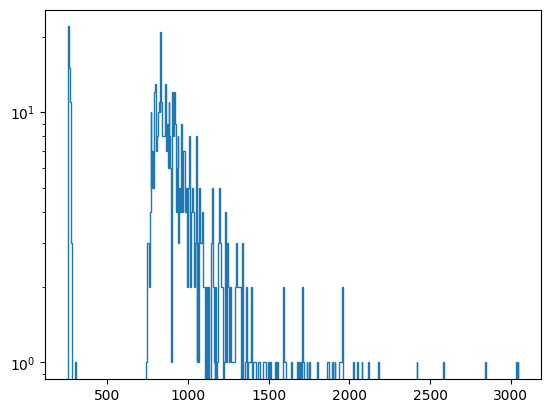

In [88]:
runDirectory = '/Users/frikken.1/documents/ret/surfaceStation/udaqTimeTesting/runs/'
run = 18
firstPanel = 0



runStringP0 = f'{runDirectory}port_{firstPanel}_run_{run:07d}/port_{firstPanel}_run_{run:07d}'

jsonListPort0 = read_json(runStringP0)
hits = udaqChargestamps(runStringP0+".bin",0,0,1,0)

pltList = []
for i in hits:
    if( i[3] ==0):
        pltList.append(i[1])
    #print(i)
print(len(hits))
plt.hist(pltList,bins=500,histtype='step')
plt.yscale('log')


(0.0, 1000.0)

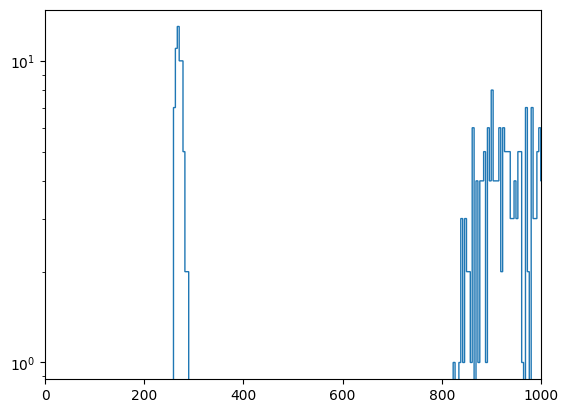

In [361]:
from scipy.signal import find_peaks
plt.hist(pltList, bins = 1000,histtype='step')
plt.yscale('log')
peaks2, _ = find_peaks(pltList, prominence=1) 
plt.xlim(0,1000)

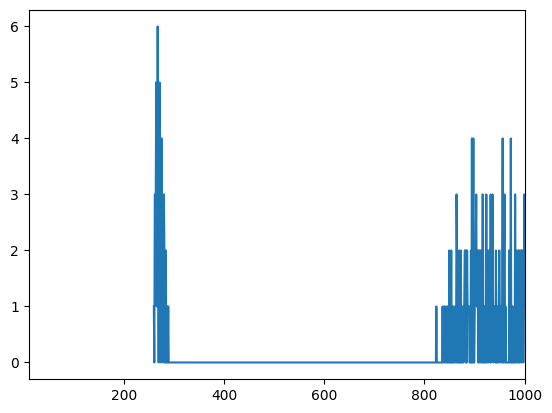

In [362]:
ages = np.array(pltList)
hist, bin_edges = np.histogram(ages, 4000)
bin_edges = bin_edges[1:]

plt.plot(bin_edges, hist)
plt.xlim(10,1000)
peaks, _ = find_peaks(hist, prominence=50)
plt.plot(bin_edges[peaks], hist[peaks], "x")


In [363]:
bin_edges[1] - bin_edges[0]

0.9590000000000032

In [364]:
for n,i in enumerate(peaks):
    if(n+1 < len(peaks)):
        print((peaks[n+1] - i)* (bin_edges[1] - bin_edges[0]))

In [365]:
16268796 - 16262500

6296

In [366]:
1691715209413599744 - 1691715209406652837

6946907

In [367]:
1691715209301683485  - 1691715209294687485

6996000

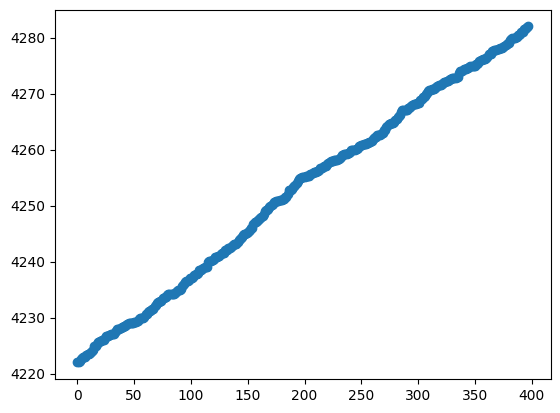

In [368]:
hits = udaqChargestamps(runStringP0+".bin",0,0,0,0)
pltlist = []
pltxlist = []
for n,i in enumerate(hits):
    #print(i)
    pltlist.append(i[0])
    pltxlist.append(n)
   

plt.scatter(pltxlist,pltlist)
       

In [9]:
runDirectory = '/Users/frikken.1/documents/ret/surfaceStation/udaqTimeTesting/runs/'
run = 3
firstPanel = 0



runStringP0 = f'{runDirectory}port_{firstPanel}_run_{run:07d}/port_{firstPanel}_run_{run:07d}'

jsonListPort0 = read_json(runStringP0)
dfPort0 = read_bin(runStringP0,jsonListPort0)
display(dfPort0)

{

    "subruntime": 20
    "runtime": 3
    "uid": "240004 48535005 20353041"
    "temperature": 296.0312
    "voltage": 2622
    "threshold": 1770
    "date": "2023-08-11"
    "subruns": 1
    "runTimes": []
    "udaqTimeSubRuns": []
    "udaq_time": "0 1450 949690"
    "time": 1691768524713041381

}
1691768524713041381
1450.94969
total hits including CPU triggers = 206 
non-CPU trigger hits = 186

panel 12 dataframe


,adc 1,adc 2,CPU trigger Flag,timeValue
0,837,33,0,1691768524769808225
1,1038,42,0,1691768525189261464
2,1310,53,0,1691768525530345781
3,835,32,0,1691768525531267974
4,957,37,0,1691768525534866487
...,...,...,...,...
201,956,38,0,1691768544424109686
202,4095,173,0,1691768544526916887
203,839,33,0,1691768544651801918
204,887,35,0,1691768544748420250


In [19]:
import heapq
 
def closest(lst, K):
    #using heapq.nsmallest() to find the element in the list with the smallest absolute difference with K
    return heapq.nsmallest(1, lst, key=lambda x: abs(x-K))[0]

In [18]:
port0List = []
port1List = []
path = "/Users/frikken.1/documents/ret/surfaceStation/udaqTimeTesting/runs/"
f = open(path+"gpioPort0.txt", "r")
i=0
for x in f:
    i+=1
    num = x.strip('\n').split('.')
    numVal = num[0]+num[1]
    #print(num)
    timeVal = np.uint64(numVal)
    #print(timeVal)
    port0List.append(timeVal)
    #print(numVal)
print(len(port0List))

190


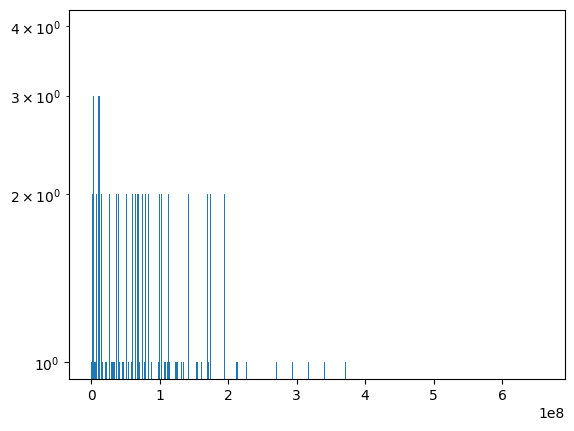

In [31]:
pltList=[]
dataList=[]
for i in dfPort0.index:
    if i < len(dfPort0) - 1:
        
        pltList.append(dfPort0.iloc[i+1,3] - dfPort0.iloc[i,3])
    testVal = dfPort0.iloc[i,3]
    dataList.append(testVal)
    #print(testVal)

plt.hist(pltList, bins=1000)
plt.yscale('log')

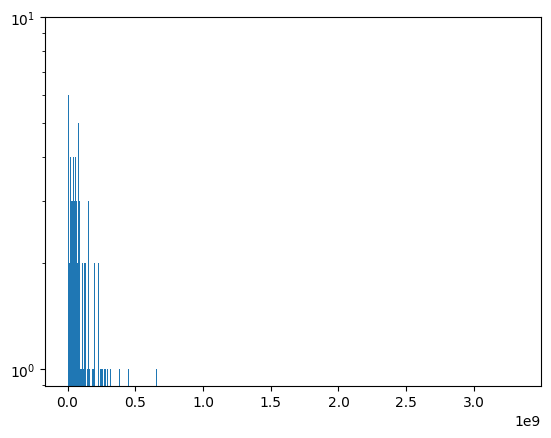

In [35]:
plt2List = []
for n,i in enumerate(port0List):
    #print()
    if n < len(port0List)-1:
        plt2List.append(port0List[n+1] - i)
plt.hist(plt2List, bins=1000)
plt.yscale('log')

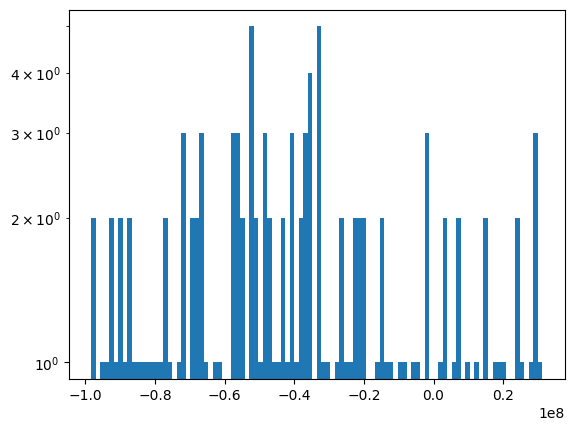

In [42]:
compareList= []
for n,i in enumerate(pltList):
    if abs(i - plt2List[n]) < 1e8:
        compareList.append(i - plt2List[n])

plt.hist(compareList,bins = 100)
plt.yscale('log')

In [32]:
pltList = []
j =0
for n,i in enumerate(port0List):
    
    
    if (abs(closest(dataList,i)- i)) < 1e8:
        j+=1
        #print(closest(dataList,i)- i)
        pltList.append(closest(dataList,i)- i)
print(j)

186


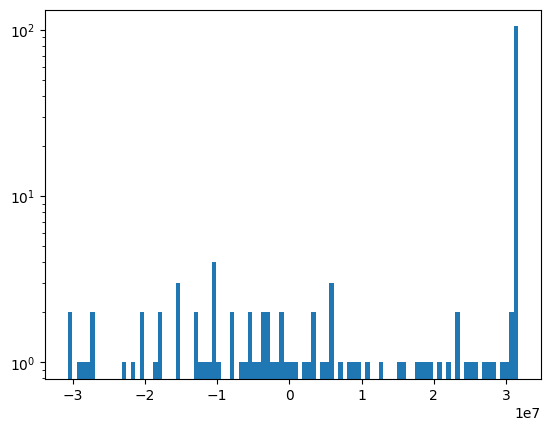

In [29]:
plt.hist(pltList,bins = 100)
plt.yscale('log')

In [124]:
#fill panda frame
#/Users/frikken.1/documents/ret/surfaceStation/summitSiteRuns/runs

#runDirectory = '/Users/frikken.1/documents/ret/surfaceStation/summitSiteRuns/runs/'
#runDirectory = '/Users/frikken.1/documents/ret/retCRAnalysis/panelRootFiles/'
runDirectory = '/Users/frikken.1/documents/ret/surfaceStation/udaqTimeTesting/runs/'
run = 16
firstPanel = 0
secondPanel = 1


runStringP0 = f'{runDirectory}port_{firstPanel}_run_{run:07d}/port_{firstPanel}_run_{run:07d}'

jsonListPort0 = read_json(runStringP0)
dfPort0 = read_bin(runStringP0,jsonListPort0)
display(dfPort0)



runStringP1 = f'{runDirectory}port_{secondPanel}_run_{run:07d}/port_{secondPanel}_run_{run:07d}'



jsonListPort1 = read_json(runStringP1)
dfPort1 = read_bin(runStringP1,jsonListPort1)
display(dfPort1)

{

    "subruntime": 20
    "runtime": 3
    "uid": "240004 48535005 20353041"
    "temperature": 296.3438
    "voltage": 2622
    "threshold": 1770
    "date": "2023-08-11"
    "subruns": 1
    "runTimes": []
    "udaqTimeSubRuns": []
    "udaq_time": "0 4806 588353"
    "time": 1691771880403798048

}
1.5883530000000974
[1.7323010166666666, 2084, 84, 0, 0]
0.1439480166665692 143948016 1691771880547746064
[1.8416538590277778, 787, 30, 0, 0]
0.2533008590276804 253300859 1691771880657098907
[1.9999993784722223, 267, 9, 0, 1]
0.41164637847212493 411646378 1691771880815444426
[2.0252084166666666, 1232, 49, 0, 0]
0.43685541666656924 436855416 1691771880840653464
[2.3179095833333334, 964, 38, 0, 0]
0.729556583333236 729556583 1691771881133354631
[2.6613251333333334, 1541, 61, 0, 0]
1.072972133333236 1072972133 1691771881476770181
[2.6926717, 760, 30, 0, 0]
1.1043186999999026 1104318699 1691771881508116747
[2.8585919993055557, 3034, 123, 0, 0]
1.2702389993054584 1270238999 1691771881674037047

,adc 1,adc 2,CPU trigger Flag,timeValue
0,2084,84,0,1691771880547746064
1,787,30,0,1691771880657098907
2,267,9,1,1691771880815444426
3,1232,49,0,1691771880840653464
4,964,38,0,1691771881133354631
...,...,...,...,...
173,1012,41,0,1691771900040034774
174,784,31,0,1691771900050572347
175,1235,49,0,1691771900111048669
176,1316,53,0,1691771900165547397


{

    "subruntime": 20
    "runtime": 3
    "uid": "240045 48535005 20353041"
    "temperature": 296.2188
    "voltage": 2601
    "threshold": 1830
    "date": "2023-08-11"
    "subruns": 1
    "runTimes": []
    "udaqTimeSubRuns": []
    "udaq_time": "0 4803 924360"
    "time": 1691771880394388548

}
1.9243599999999788
[2.210411536111111, 884, 34, 0, 0]
0.28605153611113243 286051536 1691771880680440084
[2.2529273305555555, 973, 37, 0, 0]
0.32856733055557674 328567330 1691771880722955878
[2.3705905131944442, 1194, 46, 0, 0]
0.4462305131944655 446230513 1691771880840619061
[2.40912425, 959, 37, 0, 0]
0.4847642500000213 484764250 1691771880879152798
[2.6632916972222223, 907, 35, 0, 0]
0.7389316972222435 738931697 1691771881133320245
[2.999999422916667, 266, 8, 0, 1]
1.0756394229166881 1075639422 1691771881470027970
[3.0067072319444446, 1345, 52, 0, 0]
1.0823472319444658 1082347231 1691771881476735779
[3.06042975, 1002, 38, 0, 0]
1.1360697500000212 1136069750 1691771881530458298
[3.20397

,adc 1,adc 2,CPU trigger Flag,timeValue
0,884,34,0,1691771880680440084
1,973,37,0,1691771880722955878
2,1194,46,0,1691771880840619061
3,959,37,0,1691771880879152798
4,907,35,0,1691771881133320245
...,...,...,...,...
163,928,35,0,1691771899671025531
164,956,37,0,1691771899757078041
165,957,37,0,1691771899980584613
166,955,36,0,1691771900111014294


In [125]:
coincidentList = []
cpuTrigList = []
adcList = []

#for i in range(20):

for i in dfPort0.index:
  
    testVal = dfPort0.iloc[i,3]
    #print(dfPort0.iloc[i])
    #print(len(str(testVal)))
    #if()
    #print((dfPort1['timeValue']-testVal).abs().idxmin())
    df_closest = dfPort1.iloc[(dfPort1['timeValue']-testVal).abs().argsort()[:1]]
    test = df_closest['timeValue'].tolist()
    #print(dfPort0['CPU trigger Flag'].tolist()[0])
    #print(test[0])
    #print(df_closest['CPU trigger Flag'].tolist()[0])
    #print(dfPort0['CPU trigger Flag'].tolist()[0])
    #print(test[0]-testVal)
    if(len(str(testVal)) != 19 or len(str(test[0])) !=19):
        print(f'length testval = {len(str(testVal))} length test = {len(str(test[0]))} index {i}')
    if(df_closest['CPU trigger Flag'].tolist()[0] ==0 and dfPort0.iloc[i]['CPU trigger Flag'] ==0):
        #print(f'length testval = {len(str(testVal))} length test = {len(str(test[0]))}')
        coincidentList.append(test[0] - testVal)
        adcList.append([dfPort0.iloc[i]['adc 1'],df_closest['adc 1'].tolist()])

In [126]:
print(len(coincidentList))
print(coincidentList[:10])

146
[132694020, 23341177, -34403, -34386, -34402, 22341551, -34405, 22274099, 485256, -35949874]


52.0
[-232531.80000001]


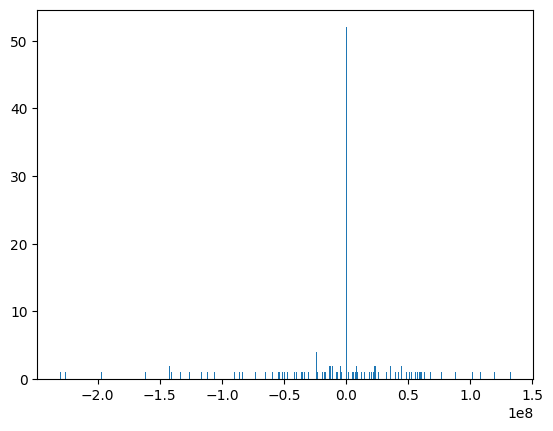

In [127]:
y, x, _ = plt.hist(coincidentList, bins = 500)

#print (x.max())
print(y.max()) 
print(x[np.where(y == y.max())])
coincidentValue = int(x[np.where(y == y.max())])


mode is -34405
51


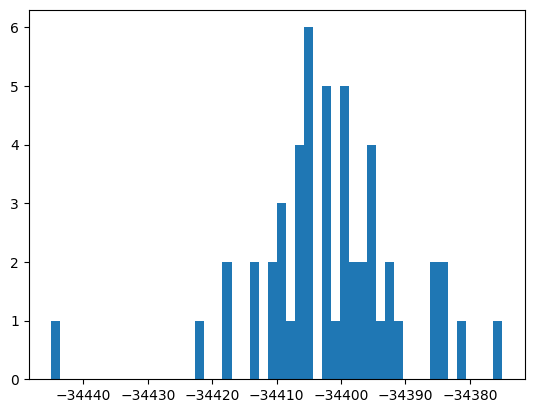

In [128]:

modeValue = statistics.mode(coincidentList)
print(f'mode is {modeValue}')
pltList = []
p0adcPlotList = []
p1adcPlotList = []
timeDiffList = []
for n,i in enumerate(coincidentList):
    if (i < modeValue+100 and i > modeValue-100):
        pltList.append(i)
        p0adcPlotList.append(adcList[n][0])
        p1adcPlotList.append(adcList[n][1])
        timeDiffList.append(modeValue - i)

#plt.hist(pltList, bins = 100)
y, x, _ = plt.hist(pltList, bins = 50)

#print (x.max())
#print(y.max()) 
print(len(pltList))


/var/folders/p0/8rnd2871535c8sq12kgg3zs00000gr/T/ipykernel_2859/872995561.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(p0adcPlotList,p1adcPlotList, c = timeDiffList,cmap=plt.cm.get_cmap('jet'))


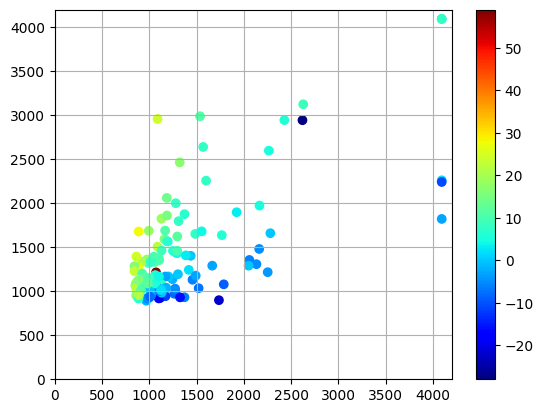

In [339]:
plt.scatter(p0adcPlotList,p1adcPlotList, c = timeDiffList,cmap=plt.cm.get_cmap('jet'))
plt.colorbar()
plt.ylim(0,4200)
plt.xlim(0,4200)
plt.grid()

In [877]:
testList = [1,3,2,24,0]

for n,i in enumerate(testList):
    print(n,i)

0 1
1 3
2 2
3 24
4 0


In [702]:
4000/30

133.33333333333334

In [521]:
50*60

3000

In [476]:
time.clock_gettime_ns(time.CLOCK_REALTIME)

1707149473783313000

In [80]:
runDirectory = '/Users/frikken.1/documents/ret/retCRAnalysis/panelRootFiles/'

run=1
firstPanel = 3
runStringP0 = f'{runDirectory}panel{firstPanel}_run_{run:07d}/panel{firstPanel}_run_{run:07d}'
jsonListPort0 = read_json(runStringP0)
hits = udaqChargestamps(runStringP0+".bin",0,0,0,0)

dfPort0 = read_bin(runStringP0,jsonListPort0)
display(dfPort0)

{

    "subruntime": 80
    "runtime": 2267
    "uid": "240045 48535005 20353041"
    "temperature": 295.1562
    "voltage": 2590
    "threshold": 1570
    "subruns": 28
    "date": "2023-04-04"
    "time": "20:22:12:255875"
    "udaq_time": "0 225 51982"

225.051982
}
total hits including CPU triggers = 108847 
non-CPU trigger hits = 106624

panel 3 dataframe


,Event Times,adc 1,adc 2,DAQ Time,CPU trigger Flag,unix Time,subSecond,timeValue
0,20:22:12.467539,609,22,0.211664,0,1680639732,467539049,1680639732467539049
1,20:22:12.476086,876,32,0.220211,0,1680639732,476085690,1680639732476085690
2,20:22:12.477466,750,27,0.221591,0,1680639732,477465638,1680639732477465638
3,20:22:12.488261,677,24,0.232386,0,1680639732,488261402,1680639732488261402
4,20:22:12.495182,628,22,0.239307,0,1680639732,495182102,1680639732495182102
...,...,...,...,...,...,...,...,...
108842,20:59:58.809079,613,22,2266.553204,0,1680641998,809078728,1680641998809078728
108843,20:59:58.838336,594,21,2266.582461,0,1680641998,838336116,1680641998838336116
108844,20:59:58.842168,597,22,2266.586293,0,1680641998,842168495,1680641998842168495
108845,20:59:58.850212,594,21,2266.594337,0,1680641998,850212016,1680641998850212016


In [6]:
time.time_ns()

1704985991115657000

In [75]:
import string
checkList = []
firstStamp = pd.to_datetime(jsonListPort0[4], format='%Y-%m-%dT%H:%M:%S:%fZ')
for n,hit in enumerate(hits):
    #if not hit[4]:
        #hitCounter+=1
    #daqTimeAdjust = hit[0] - jsonList[2]
    #daqTimeValue = (hit[0] - jsonList[2])
    numVal = str((hit[0] - float(jsonListPort0[2])))
    #print(numVal)
    #print(numVal[:numVal.find(".")+10])
    #print(int(float(numVal[:numVal.find(".")+10])*1e9))
    timeValueNS = int(float(numVal[:numVal.find(".")+10])*1e9)
    pandaTimeString = str(firstStamp.value+timeValueNS)
    #print(pandaTimeString)
    checkList.append(pandaTimeString)
    

In [13]:
count=0
timeList =[]
cpuTrigList=[]
for i in hits:
    #print(float('%.9f' % i[0]) - float('%.9f' % jsonListPort0[2]))
    count+=1
    timeVal = (i[0] -jsonListPort0[2])*1e9
    timeList.append(int(timeVal))
    if( i[4] ==1):
        cpuTrigList.append((i[0] -jsonListPort0[2])*1e9)
    #print(i[0],int(timeVal))
    

3575 3575


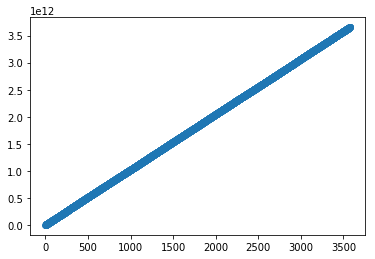

In [14]:
x = range(len(cpuTrigList))
yList=[]
for i in x:
    yList.append(cpuTrigList[i])
print(len(x),len(yList))
plt.scatter(x,yList)

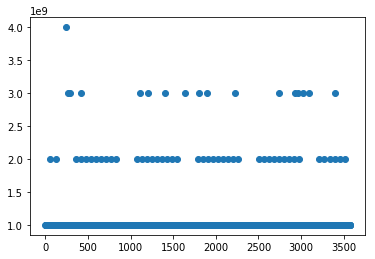

In [15]:
diffList = []
for n,i in enumerate(cpuTrigList):
    if n>0:
        diffList.append(i - cpuTrigList[n-1])
        
x = range(len(diffList))
plt.scatter(x,diffList)
    

20 20


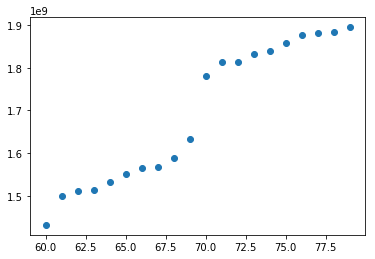

In [16]:
x = range(60,80)
yList=[]
for i in x:
    yList.append(timeList[i])
print(len(x),len(yList))
plt.scatter(x,yList)

(array([17355., 17551., 17871., 17521., 17628., 17796., 17484., 17774.,
        17578., 17924.]),
 array([3.25102727e+08, 3.65831319e+11, 7.31337536e+11, 1.09684375e+12,
        1.46234997e+12, 1.82785619e+12, 2.19336240e+12, 2.55886862e+12,
        2.92437484e+12, 3.28988105e+12, 3.65538727e+12]),
 <a list of 10 Patch objects>)

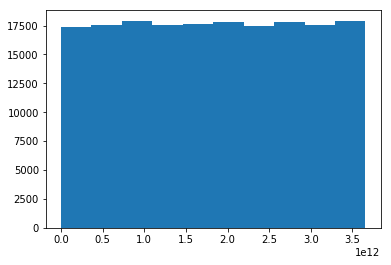

In [17]:
plt.hist(timeList)

In [192]:
runDirectory = '/fs/project/PAS1968/retcr/data/summit2023/SUR/43/runs/'

run=65
firstPanel = 1



runStringP0 = f'{runDirectory}panel{firstPanel}_run_{run:07d}/panel{firstPanel}_run_{run:07d}'

jsonListPort0 = read_json(runStringP0)
print(jsonListPort0)
dfPort0 = read_bin(runStringP0,jsonListPort0)
display(dfPort0)




{

    "subruntime": 60
    "runtime": 3600
    "uid": "24002f 48535005 20353041"
    "temperature": 263.1562
    "voltage": 2495
    "threshold": 1580
    "subruns": 60
    "date": "2023-06-16"
    "time": "00:09:34:235934"
    "udaq_time": "0 77614 905856"

}
['2023-06-16', '00:09:34.235934', 77614.905856, 1, '2023-06-16T00:09:34:235934000Z']
total hits including CPU triggers = 176482 
non-CPU trigger hits = 172907

panel 1 dataframe


,Event Times,adc 1,adc 2,DAQ Time,CPU trigger Flag,unix Time,subSecond,timeValue
0,00:09:34.561037,1188,47,0.325103,0,1686874174,561036727,1686874174561036727
1,00:09:34.570457,593,22,0.334523,0,1686874174,570456522,1686874174570456522
2,00:09:34.589857,1113,44,0.353923,0,1686874174,589856522,1686874174589856522
3,00:09:34.610858,693,27,0.374924,0,1686874174,610858300,1686874174610858300
4,00:09:34.621095,613,23,0.385161,0,1686874174,621095017,1686874174621095017
5,00:09:34.626957,602,23,0.391023,0,1686874174,626957221,1686874174626957221
6,00:09:34.649293,595,23,0.413359,0,1686874174,649293099,1686874174649293099
7,00:09:34.675266,632,24,0.439332,0,1686874174,675265994,1686874174675265994
8,00:09:34.711862,1323,53,0.475928,0,1686874174,711861883,1686874174711861883
9,00:09:34.754671,1862,75,0.518737,0,1686874174,754671156,1686874174754671156


In [136]:
runStringP0

'/fs/project/PAS1968/retcr/data/summit2023/SUR/43/runs/panel1_run_0000065/panel1_run_0000065'

In [95]:
timeDiffList = []
timeErrors =0
for i in dfPort0.index:
    #print(dfPort0.iloc[i,4])
    if( dfPort0.iloc[i,4] != 1 and i >0):
        timeDiffList.append(dfPort0.iloc[i,7] - dfPort0.iloc[i-1,7])
        if (dfPort0.iloc[i,7] - dfPort0.iloc[i-1,7]) <0:
            timeErrors+=1
            #print(dfPort0.loc[i-1])
            #print(dfPort0.loc[i])
            #print(' ')
print(f'time errors in file {timeErrors}')

time errors in file 52


(-25000000.0, 150000000.0)

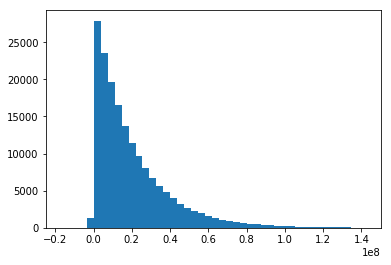

In [96]:
plt.hist(timeDiffList,bins = 1000)
plt.xlim(-.025e9,.15e9)

In [97]:
for i in timeDiffList:
    if i < 0:
        print(i)

-1934222
-22756
-204800
-250311
-45511
-227555
-45511
-318578
-627194890
-68
-255
-1
-40
-33
-1013
-8
-813386066
-773689
-68266
-22756
-113778
-227555
-955733
-22755
-91023
-68267
-386844
-182044
-649194362
-477600570
-353896206
-202994073
-68266
-204800
-172302814
-773689
-113778
-182044
-45511
-159289
-773689
-182044
-273067
-22756
-318577
-312640015
-162567097
-204800
-136533
-1069511
-68266
-285582397


In [83]:

cpuTrigList = []
for i in dfPort0.index:
    #print(dfPort0.iloc[i,4])
    if( dfPort0.iloc[i,4] == 1):
        cpuTrigList.append(dfPort0.iloc[i,7])
   

In [84]:
cpuTrigList

[1686874175330077377,
 1686874176330077377,
 1686874177330077377,
 1686874178330077377,
 1686874179330077355,
 1686874180330077377,
 1686874181330077399,
 1686874182330077377,
 1686874183330077377,
 1686874184330077377,
 1686874185330077399,
 1686874186330077422,
 1686874187330077377,
 1686874188330077377,
 1686874189330077377,
 1686874190330077377,
 1686874191330077377,
 1686874192330077377,
 1686874193330077399,
 1686874194330077377,
 1686874195330077377,
 1686874196330077377,
 1686874197330077399,
 1686874198330077377,
 1686874199330077377,
 1686874200330077377,
 1686874201330077377,
 1686874202330077377,
 1686874203330077377,
 1686874204330077422,
 1686874205330077377,
 1686874206330077377,
 1686874207330077377,
 1686874208330077377,
 1686874209330077377,
 1686874210330077377,
 1686874211330077377,
 1686874212330077377,
 1686874213330077422,
 1686874214330077377,
 1686874215330077377,
 1686874216330077377,
 1686874217330077377,
 1686874218330077399,
 1686874219330077377,
 168687422

In [93]:
range(0,len(diffList))

range(0, 3574)

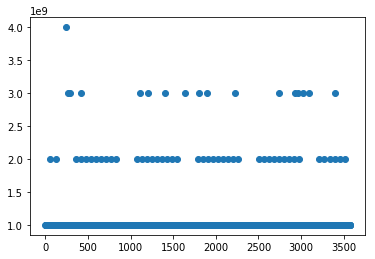

In [94]:
diffList = []
for n,j in enumerate(cpuTrigList):
        if n>0:
            #if(j - cpuTrigList[n-1]) < 1.8e9:
            diffList.append( (j - cpuTrigList[n-1]))
            #if (j - cpuTrigList[n-1]) != 1e9:
                #print(j - cpuTrigList[n-1])
      
plt.scatter(range(0,len(diffList)), diffList)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.600e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 4.400e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 8.000e+02, 2.651e+03, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        4.400e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

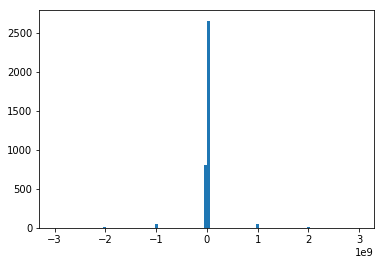

In [95]:
newList = []
for n,j in enumerate(diffList):
        if n>0:
            #if(j - cpuTrigList[n-1]) < 1.8e9:
            newList.append( j - diffList[n-1])
            #if (j - cpuTrigList[n-1]) != 1e9:
                #print(j - cpuTrigList[n-1])
                
plt.hist(newList,bins = 100)

In [88]:
newList

[0,
 0,
 -22,
 44,
 0,
 -44,
 22,
 0,
 22,
 1,
 -68,
 45,
 0,
 0,
 0,
 0,
 22,
 -44,
 22,
 0,
 22,
 -44,
 22,
 0,
 0,
 0,
 0,
 45,
 -90,
 45,
 0,
 0,
 0,
 0,
 0,
 0,
 45,
 -90,
 45,
 0,
 0,
 22,
 -44,
 22,
 45,
 -90,
 90,
 -90,
 45,
 0,
 -22,
 44,
 -22,
 0,
 0,
 0,
 0,
 0,
 0,
 22,
 -44,
 22,
 0,
 0,
 0,
 0,
 0,
 45,
 -90,
 45,
 0,
 0,
 -22,
 44,
 -22,
 22,
 1,
 -68,
 45,
 0,
 0,
 0,
 22,
 -44,
 22,
 45,
 -90,
 45,
 22,
 -44,
 22,
 0,
 22,
 1,
 -68,
 45,
 -22,
 66,
 -66,
 22,
 0,
 0,
 0,
 0,
 0,
 0,
 45,
 -90,
 45,
 22,
 -44,
 22,
 0,
 0,
 0,
 0,
 45,
 -67,
 44,
 -22,
 0,
 0,
 0,
 45,
 -90,
 45,
 0,
 0,
 45,
 -68,
 1,
 22,
 22,
 -44,
 22,
 0,
 45,
 -90,
 45,
 0,
 0,
 -22,
 44,
 -22,
 22,
 1,
 -68,
 45,
 0,
 0,
 0,
 0,
 0,
 45,
 -90,
 45,
 0,
 0,
 22,
 -44,
 22,
 0,
 0,
 0,
 22,
 -66,
 111,
 -112,
 45,
 0,
 22,
 -44,
 22,
 0,
 0,
 22,
 -44,
 22,
 0,
 0,
 0,
 0,
 45,
 -90,
 45,
 0,
 22,
 -22,
 -22,
 0,
 66,
 -66,
 44,
 -44,
 44,
 -44,
 22,
 0,
 0,
 0,
 0,
 0,
 0,
 22,
 -44,
 44,
 -44,
 2

In [32]:
1000000022 - 999999978

44

In [104]:
for i in range(167965,167978):
    print(dfPort0.loc[i])

Event Times             01:07:33.127926
adc 1                               832
adc 2                                32
DAQ Time                        3478.89
CPU trigger Flag                      0
unix Time                    1686877653
subSecond                     127925900
timeValue           1686877653127925900
Name: 167965, dtype: object
Event Times             01:07:33.179997
adc 1                              1771
adc 2                                71
DAQ Time                        3478.94
CPU trigger Flag                      0
unix Time                    1686877653
subSecond                     179997234
timeValue           1686877653179997234
Name: 167966, dtype: object
Event Times             01:07:33.194088
adc 1                               581
adc 2                                22
DAQ Time                        3478.96
CPU trigger Flag                      0
unix Time                    1686877653
subSecond                     194087733
timeValue           1686

In [7]:
print(dfPort0.loc[54502])
print(dfPort0.loc[54503])
print(dfPort0.loc[54504])
print(dfPort0.loc[54505])

Event Times             00:28:27.216244
adc 1                               569
adc 2                                22
DAQ Time                        1132.98
CPU trigger Flag                      0
unix Time                    1686875307
subSecond                     216244338
timeValue           1686875307216244338
Name: 54502, dtype: object
Event Times             00:28:27.277224
adc 1                               692
adc 2                                30
DAQ Time                        1133.04
CPU trigger Flag                      0
unix Time                    1686875307
subSecond                     277223550
timeValue           1686875307277223550
Name: 54503, dtype: object
Event Times             00:28:26.628029
adc 1                               604
adc 2                                23
DAQ Time                        1132.39
CPU trigger Flag                      0
unix Time                    1686875306
subSecond                     628029188
timeValue           168687

In [8]:
hits = udaqChargestamps(runStringP0+".bin")

In [9]:
for i in range(54480,54530):
    print(i,hits[i][0])

54480 78747.42554742709
54481 78747.45162866528
54482 78747.46327656042
54483 78747.48475702848
54484 78747.49551066944
54485 78747.51389197222
54486 78747.55332056736
54487 78747.57571926528
54488 78747.57983145486
54489 78747.60538377153
54490 78747.63103144862
54491 78747.63866806598
54492 78747.6698990993
54493 78747.69700026042
54494 78747.71649521042
54495 78747.72633424097
54496 78747.75501299306
54497 78747.78619835139
54498 78747.80552857778
54499 78747.83092630556
54500 78747.84662962014
54501 78747.8634527389
54502 78747.8861663389
54503 78747.9471455507
54504 78747.29795118888
54505 78747.31674075486
54506 78747.33456264445
54507 78747.38575598889
54508 78747.48545773889
54509 78747.48569028472
54510 78747.62487088265
54511 78747.66319731667
54512 78747.66945578888
54513 78747.67230940555
54514 78747.70064899445
54515 78747.70612351666
54516 78747.71122513195
54517 78747.7122502889
54518 78747.71885705486
54519 78747.71968891597
54520 78747.73069576111
54521 78747.734628909

In [116]:
jsonListPort0 = read_json(runStringP0)

{

    "subruntime": 60
    "runtime": 3600
    "uid": "24002f 48535005 20353041"
    "temperature": 263.1562
    "voltage": 2495
    "threshold": 1580
    "subruns": 60
    "date": "2023-06-16"
    "time": "01:10:31:654825"
    "udaq_time": "0 81272 351243"

}


In [115]:
jsonListPort0

['2023-06-16',
 '01:10:31.654825',
 81272.351243,
 1,
 '2023-06-16T01:10:31:654825000Z']

In [137]:
#fill panda frame
#/Users/frikken.1/documents/ret/surfaceStation/summitSiteRuns/runs

#runDirectory = '/Users/frikken.1/documents/ret/surfaceStation/summitSiteRuns/runs/'
runDirectory = '/fs/project/PAS1968/retcr/data/summit2023/SUR/43/runs/'

run=66
firstPanel = 1
secondPanel = 2


runStringP0 = f'{runDirectory}panel{firstPanel}_run_{run:07d}/panel{firstPanel}_run_{run:07d}'

jsonListPort0 = read_json(runStringP0)
dfPort0 = read_bin(runStringP0,jsonListPort0)
display(dfPort0)

run=73

runStringP1 = f'{runDirectory}panel{secondPanel}_run_{run:07d}/panel{secondPanel}_run_{run:07d}'



jsonListPort1 = read_json(runStringP1)
dfPort1 = read_bin(runStringP1,jsonListPort1)
display(dfPort1)

{

    "subruntime": 60
    "runtime": 3600
    "uid": "24002f 48535005 20353041"
    "temperature": 263.1562
    "voltage": 2495
    "threshold": 1580
    "subruns": 60
    "date": "2023-06-16"
    "time": "01:10:31:654825"
    "udaq_time": "0 81272 351243"

}
total hits including CPU triggers = 181390 
non-CPU trigger hits = 177808

panel 1 dataframe


,Event Times,adc 1,adc 2,DAQ Time,CPU trigger Flag,unix Time,subSecond,timeValue
0,01:10:32.011684,832,33,0.356859,0,1686877832,11683605,1686877832011683605
1,01:10:32.017936,2469,100,0.363111,0,1686877832,17936166,1686877832017936166
2,01:10:32.023359,602,23,0.368534,0,1686877832,23359233,1686877832023359233
3,01:10:32.028416,1251,50,0.373591,0,1686877832,28415831,1686877832028415831
4,01:10:32.036632,573,22,0.381807,0,1686877832,36631905,1686877832036631905
5,01:10:32.059604,752,29,0.404779,0,1686877832,59603925,1686877832059603925
6,01:10:32.064409,591,23,0.409584,0,1686877832,64409244,1686877832064409244
7,01:10:32.077979,619,24,0.423154,0,1686877832,77979300,1686877832077979300
8,01:10:32.085350,756,29,0.430525,0,1686877832,85350389,1686877832085350389
9,01:10:32.099195,558,21,0.444370,0,1686877832,99195465,1686877832099195465


{

    "subruntime": 60
    "runtime": 3600
    "uid": "240032 48535005 20353041"
    "temperature": 264.7188
    "voltage": 2510
    "threshold": 1580
    "subruns": 60
    "date": "2023-06-16"
    "time": "01:09:20:298846"
    "udaq_time": "0 81184 948939"

}
total hits including CPU triggers = 153393 
non-CPU trigger hits = 149823

panel 2 dataframe


,Event Times,adc 1,adc 2,DAQ Time,CPU trigger Flag,unix Time,subSecond,timeValue
0,01:09:20.613953,1734,70,0.315107,0,1686877673,211648542,1686877673211648542
1,01:09:20.615306,679,26,0.316460,0,1686877673,213002278,1686877673213002278
2,01:09:20.619747,571,22,0.320901,0,1686877673,217442578,1686877673217442578
3,01:09:20.674583,735,29,0.375737,0,1686877673,272279139,1686877673272279139
4,01:09:20.739721,614,23,0.440875,0,1686877673,337417323,1686877673337417323
5,01:09:20.814227,644,25,0.515381,0,1686877673,411923259,1686877673411923259
6,01:09:20.820872,787,30,0.522026,0,1686877673,418567872,1686877673418567872
7,01:09:20.827061,678,26,0.528215,0,1686877673,424756947,1686877673424756947
8,01:09:20.840134,650,25,0.541288,0,1686877673,437829936,1686877673437829936
9,01:09:20.862180,654,25,0.563334,0,1686877673,459875528,1686877673459875528


In [112]:
count =0
for i in dfPort0.index:
    #print(dfPort0.iloc[i,7])
    if i == 0:
        continue
        
    timeDiff = dfPort0.iloc[i,7] - dfPort0.iloc[i-1,7]
    if(timeDiff < 0):
        print(i, timeDiff)
        #print(timeDiff)
    

1319 -327686569
2310 -446330197
12108 -100163219
25658 -432355
25660 -227555
25661 -91022
25662 -22757
25663 -22754
42839 -264610239
56100 -69494250
56102 -136533
56103 -22756
56106 -591645
56108 -386844
56109 -113778
56112 -182044
56113 -22756
56114 -22755
56116 -841956
56117 -136533
56118 -22755
56119 -45511
56121 -159289
56123 -68267
56124 -45511
89886 -30875917
99385 -96831612
99386 -250311
99387 -159289
99388 -22756
99389 -68266
99392 -136533
99394 -45511
99395 -22755
99396 -22756
99399 -477867
142329 -101350393
142331 -523378
142333 -250311
142334 -273067
152072 -465295645
175612 -282049431


In [113]:
def plotADCHist(port):
    #print(f'{df=}'.split('=')[0])
    df = globals()[f'dfPort{port}']
    jsonList = globals()[f'jsonListPort{port}']
    timeList = []
    adc0List = []
    for i in range(len(df)):
    #for i in range(1000):
        if df.iloc[i, 4] ==0:
            #evTime = datetime.datetime.strptime(df.iloc[i, 0], '%H:%M:%S.%f')
            evTime = df.iloc[i,5]
            timeList.append(evTime)
            adc0List.append(df.iloc[i, 1])


    plt.hist(adc0List, bins = 400,histtype='step')
    # plt.axvline(x = statistics.mode(adc0List), label = f' mode {statistics.mode(adc0List)} adc', color='r')
    plt.legend()
    plt.title(f'Panel {jsonList[3]} High Gain')
    plt.ylabel('counts')
    plt.xlabel('adc charge')
    plt.show()

def plotADCHist(port):
    #print(f'{df=}'.split('=')[0])
    df = globals()[f'dfPort{port}']
    jsonList = globals()[f'jsonListPort{port}']
    timeList = []
    adc0List = []
    for i in range(len(df)):
    #for i in range(1000):
        if df.iloc[i, 4] ==0:
            evTime = datetime.datetime.strptime(df.iloc[i, 0], '%H:%M:%S.%f')
            timeList.append(evTime)
            adc0List.append(df.iloc[i, 1])


    plt.hist(adc0List, bins = 400,histtype='step')
    # plt.axvline(x = statistics.mode(adc0List), label = f' mode {statistics.mode(adc0List)} adc', color='r')
    plt.legend()
    plt.title(f'Panel {jsonList[3]} High Gain')
    plt.ylabel('counts')
    plt.xlabel('adc charge')
    plt.show()

No handles with labels found to put in legend.


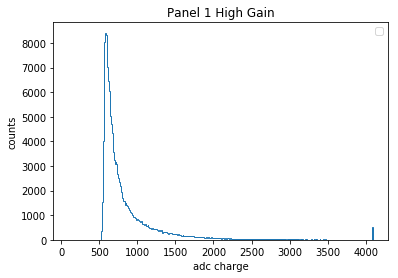

No handles with labels found to put in legend.


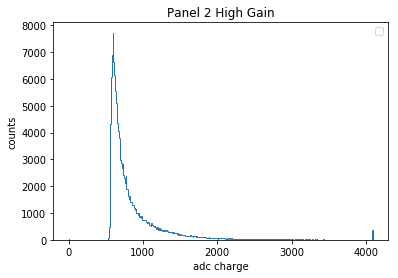

In [114]:

plotADCHist(0)
plotADCHist(1)

# coincidence check new time value to nanosecond

In [38]:
dfPort1.iloc[10000,7]

1686877999018491133

In [39]:
testVal = dfPort1.iloc[10000,7]

In [40]:


df_closest = dfPort0.iloc[(dfPort0['timeValue']-testVal).abs().argsort()[:1]]

In [41]:
test = df_closest['timeValue'].tolist()

In [45]:
df_closest['CPU trigger Flag'].tolist()[0]

0

In [38]:
test[0] - testVal

7619001

In [73]:
count =0
for i in dfPort0.index:
    print(i)
    testVal = dfPort0.iloc[i+10000,7]
    print(testVal)
    count+=1
    if count > 3:
        break

0
1686878039415628269
1
1686878039444471083
2
1686878039449910370
3
1686878039466038444


In [119]:
type(dfPort0['timeValue'][0])

numpy.int64

In [ ]:
closest_index = (data.col1 - data.col2).abs().idxmin()
print(data.loc[closest_index, :])

In [183]:
coincidentList = []
cpuTrigList = []
for i in range(20010):
#for i in dfPort0.index:
    testVal = dfPort0.iloc[i,7]
    #print(dfPort0.loc[i])
    #print(testVal)
    #if()
    #print((dfPort1['timeValue']-testVal).abs().idxmin())
    df_closest = dfPort1.iloc[(dfPort1['timeValue']-testVal).abs().argsort()[:1]]
    test = df_closest['timeValue'].tolist()
    #print(test[0])
    #print(test[0]-testVal)
    if(df_closest['CPU trigger Flag'].tolist()[0] ==0 and dfPort0['CPU trigger Flag'].tolist()[0] ==0):
        coincidentList.append(test[0] - testVal)
    

-3157265
-2736389
-8159456
6081443
-2134631
8421719
3616400
-9953656
-17324745
15445228
7283307
5686419
-12495343
6936370
2145958
-4726469
-13048447
13858033
-16697259
8440440
-979689
-4964075
-11907075
-29407614
44263425
23409201
1394940
-16174521
2977578
1280446
3149231
7105917
-7905167
6068563
-4513693
-7809147
10443509
2788931
-16588972
4610089
2085614
1525701
-2891370
-12291838
-17870286
13069341
3641552
1615648
12047
-16293491
-6300485
-4018570
-3146434
-3393645
7840139
2393572
-16988828
39275071
30878555
13745287
-4761899
6516804
8555507
-16131328
-22297090
15231111
-6460168
4233311
-83592
1538176
4992543
-6324589
-8565299
-45268720
37594837
33608160
27867909
24529937
13200016
14013987
-14258088
14673222
1119495
-468738
-6396316
9551944
5313524
-2665811
-4296300
12625911
7699594
2602125
2424476
-4356362
-6891994
-9784980
-14988980
-4201804
5294910
-26499333
22303364
9910884
-4196836
-4307355
-10188819
3685143
30201764
28391352
23391200
6238329
-2972545
-1465523
2662295
-5347271


-32040
-2121244
-5405111
-11958950
30639308
4606078
-12942051
-17733613
-15867721
-24063055
-264334
1285091
-5741498
-18262498
2734944
-3752508
-6138392
-13120192
17809420
-16672473
-12541013
-15468716
20952038
8971761
5282090
-24498846
-28735616
-36440793
29896100
9615270
-3493852
-4370146
22820355
3463639
-6515864
-7240717
1755484
122856
-962569
-7540350
-9750703
3165854
-3949866
752098
-1596747
3103475
-13594998
16047564
4147304
3832989
-7537839
6395392
-1644189
-3224304
-8017867
3972794
-4619855
-6408677
-1930144
-5688044
-7952284
10935954
1206322
-1428349
-7986261
-11635659
7337282
-2903712
5194980
106570
-6532210
-22235182
34480430
32802350
-2978471
-3584122
1693261
7374127
3248450
-1626124
-10710370
-6072031
-10043392
1753810
406835
-13213813
-22050863
-22267256
473889
-11883566
12629263
11936137
1356169
-5405242
-13740911
11383253
-492135
19429329
18135239
9289563
6947716
-22685390
-25570590
10137168
5062282
529574
4750045
-837348
3422854
-655740
-25128259
37417001
16103017
-15

-5755223
-16440611
-18941090
-22035173
-34621021
-42100474
25847461
4035710
-6040208
-9237431
-10432227
2967722
10582302
-4596385
5064655
-9283756
-15454754
-49541656
20437711
-17945976
-41524039
-43479375
51121864
26676389
17513528
164245
1176173
1238956
-6417483
3789439
-3275667
-4341234
-15289629
18161671
-16041729
17233627
15900673
-14771303
5419539
5246428
-5650429
-7707806
-15778773
-17150826
13579181
-5699770
-13588175
17027013
-14342289
36895435
25180089
10598989
2434177
-3251733
12290166
-8981605
-13752367
10824196
-8275998
9686978
-8968498
20940880
2165844
2743111
-7698598
-569614
-14191451
-31524549
24340453
22953806
5587776
-3807406
-1175316
-5920003
2472422
-936877
-6723868
-2190388
17648930
8396242
4865591
16114271
12420732
-3251456
-6161379
-9155195
-12834129
-24561995
19405906
-12461362
6808630
3423556
-2552621
-7983673
-5820924
7834122
3559075
-3665482
-2386081
2778266
-8219386
7533350
4660421
7440255
7028747
-1822828
3293360
-5347805
8699994
2969906
20808181
9432317
-

-11524292
-29928629
17845316
2523766
1216150
-16277564
-233147
9497411
3886256
-5101295
1329585
-2933046
-5246863
18276425
12964669
13424199
6461971
6043573
3290933
1600488
-30999
-3784848
3912739
-9483647
13125940
10447475
4232094
-3678364
6159344
5770627
-2953445
-6054538
-11584288
-19854965
-18081562
-7271945
3678896
2438914
23694671
3838860
-4174715
885299
450821
-23773140
38171654
31663860
-4689696
-6201529
-4558449
3543864
-3404238
5639355
2081293
-21877969
4139125
-33630246
11914000
2362127
-16339026
-48297728
26995943
13229672
266202
4414703
9085173
2762323
2205612
-10156661
-11879289
-25097684
30295022
17035706
-4654099
-23302144
-33799873
-42894773
48369715
40589164
11466471
2836771
-3083561
-5785369
4253984
396623
-5998331
7525359
4878741
3089807
6284544
-3969921
-4467264
-9294192
1310216
-7669951
5508244
-1507216
-3831251
1222347
2095222
-997238
5381053
-8073818
-758983
4322255
2753589
31527689
15229184
-552498
-8011810
1784661
13448090
-21051872
-35241206
17790016
12411016

-11725074
6747972
4156734
6951893
1581557
2466655
14210117
-6871245
2801648
-1156341
1500184
300054
-25524706
-25813677
1101483
-8670459
-10575155
19912112
18986389
13690456
-16874939
6270234
9351814
-67068312
-69986318
-98969831
-129736828
-152302539
-173153712
-204440417
-209480572
-211571378
-214848721
-262059811
-281050932
-302854762
-319303148
-365458997
-367971151
-377756664
-397796730
396690889
396102923
390925651
387891958
383450739
375890384
370109854
347527489
334125871
327982285
302593966
266428634
261657789
211108973
192773898
167635316
167404522
166964047
153402467
152393621
149149944
148089811
59526303
35740840
1994739
1481799
-1206561
10847323
9776157
6231292
12924866
6547453
3040530
-1573307
-3134228
2094684
-1122256
-4274688
4856352
-20093532
-27066446
45169016
23736843
20679152
11342680
-1272799
-2938232
2322416
223223
3476611
-3659998
-18128180
-22838930
35656263
30517538
16389083
12785762
11901144
9472378
1763750
-7802408
4819781
4645461
-3646818
-4781250
-6930132
4

-15312276
6933666
-6340251
-9648762
-3006318
-7986085
-9583084
4497511
-395119
12918201
4087278
-3831504
-18674321
19225612
17911286
-33247593
-37487720
-40196081
29743661
16772183
10413609
4383779
2198556
-1900077
17708573
-657835
-19642979
14761665
-1410366
3363873
2884761
-23331006
-24815935
-25568280
264545
-3962506
-3697440
-7417180
-15385555
-3598344
-7697423
-10830910
8880237
61484
-488085
-4343406
617078
-1135964
-1478756
-1215162
-10772092
8194030
-1200654
-1932232
-5084766
4608961
-5212620
-7692931
427018
-3423732
-2358938
-3094045
-76022
-3608214
15350446
10806769
-19762423
-6421247
15851734
5581395
-411611
-467050
4834620
-3800051
3306060
-5917887
-7508523
835279
16841895
-3726889
2495494
-12739479
-19839983
20747147
6670004
14774784
-3965681
-699295
2820159
-7886159
16086015
4259939
-1937525
16541553
6182883
3671211
-7897162
-12664247
28808250
28598755
3919654
472066
-3420021
-8331023
-8570261
3880205
-13626339
28710030
24891726
-3106323
-21036695
4329368
548786
-1556143
1

-6268364
10535479
9122078
20015463
661819
7667868
-1272943
-4983204
-23427422
-25044944
29000207
16841552
4378935
3374232
-18808788
-19597831
-47962525
46380743
45518421
13785087
-31421968
-35489977
-71917663
-78499423
79179023
72557098
10450536
4930074
13263000
8823959
-10040007
-29296029
15613482
-4506711
13432947
12600102
1213933
-8421372
-25359333
-10204668
-13566133
-7484040
-13339175
-21972846
2026350
1752157
-577604
-9806462
-21686634
8048746
-7028291
5106030
-391600
-2221171
-11152144
-18063826
-21013136
23402589
8261500
3288206
5919048
1661589
1018119
-12387930
-21608719
16080640
-42798947
-1618809
13795913
10561868
4048404
-100663
-23810330
-33521224
-35175096
-40657240
-41912907
-57970923
-60088066
33867314
24007750
14215633
11026216
-7632389
2978380
12082888
2279736
-4773388
-5610076
7165833
1129422
-6177460
-888841
20912922
-25568561
-31901728
-34925395
-35812346
-43501434
36687595
23249020
23023564
17343943
-4497850
2902860
-215985
-976662
-3547064
-13087717
-18016937
-27

1355778
-29486488
2655888
2336260
1509277
-23713631
-24184842
-29768852
-39355320
-68269775
-68900884
64414756
59275802
-4953994
1218414
-484095
258490
-9191559
8005535
-13455722
-2433084
-7523378
6306075
-19724018
4702262
-1706177
-2058822
-4071830
1800383
-12071645
4020033
710750
-1612132
-10668051
11184221
-6607595
-1659794
19017592
12423717
-77455
-14829782
-12354124
5838365
5020654
2761386
-1436778
-20474306
7048112
1623640
193593
3405643
4565346
-3851889
1180041
2659404
-3866846
-5239440
-7656971
9676393
-10653831
-19105570
6071671
9507215
-10374989
19390425
9645928
-147228
-6708523
-8774507
23415211
16371730
9240014
-2383638
-8373706
3313823
-413265
-7227346
13859377
29946541
26142567
7484728
6873078
-4733233
692078
-11319446
-18140477
15425740
3473174
1230600
920161
-10385881
3847618
3297812
-4945060
-5200744
2052436
-1749458
-8700735
-10110903
-11633552
-26182500
25422286
-10475248
-10766339
13614571
3540856
6366735
-3774237
19727471
335250
6016008
1373309
11333893
-6381759
83

13537533
-2712171
9627928
-18865701
-2118775
6204455
1339643
-35732090
-36201520
32216270
28670059
1100905
-5496599
12477716
22417
-5470456
13403752
689219
-4991987
-9004781
16160684
-8839937
-30419245
-36336166
37240708
9816606
8983538
-2795013
-4451817
-14023220
6385258
9484288
-1790591
-19202541
-23183817
-37491833
7736936
-4145643
-6560788
-8002445
2927385
3460428
-1564646
-8695717
4399598
8576970
-19948117
-20792731
-21455583
1453884
175189
11052920
16007931
-6459325
14803806
6046175
-19381266
23546391
12922283
-4280511
-32382228
31564808
14482136
4588677
2641886
10247638
5030844
-15530503
-18924322
-27981509
19166714
17802333
6630027
6129261
15221931
12861697
-14109992
15530478
-17751942
7331539
2513136
-9077451
-11618159
-18869740
-42967609
47064103
46771533
15552968
3418178
1226550
-2265428
-6021588
-3675570
-12595733
13952045
18682291
7883840
3504128
-4777776
6531854
4727264
-8705499
-9983132
-11302268
3289050
2897596
-17722737
1374802
-9502296
-12421758
-20929311
-26024293
-2

11520594
3835172
-8905536
-21759406
216044
-151177
10498100
5843548
1158405
-6320535
-13766771
8708683
30058
-20552449
29597890
-602409
-979101
-3279032
-21841451
-670297
-16807697
23563211
18782300
11056600
-6430789
-10397818
-25353907
9367624
8609787
877257
-3466776
-3990376
-12541898
-3498222
-3954555
-4867933
-3088680
7589773
7157582
-7390133
-2039527
-25237780
-26472478
-51097312
49641772
48437613
33789957
-15888914
3876707
-9525160
14630811
-30843769
-2748978
5545789
-12158392
16968998
12512814
21780584
2164147
9237464
-10191626
6950762
-2060362
-4493002
912284
17127268
6537191
-14390399
2453022
450688
-20182158
31014678
30039522
12165333
5553893
-1780474
-8499412
-17335275
-1069953
-1721633
-10012350
6669133
9272441
-2943937
-8119282
-19020953
10594984
10531800
4465827
-1719556
-6245073
-15913178
-7801323
5178239
801464
-6943238
14080077
2086059
1415213
-7374827
-17345755
-28028327
30524583
23494336
20823757
6276733
1238500
-2171930
-5593728
5088872
3976617
3091861
-4710261
1001

21527472
-2073294
3875750
3461321
-9420836
-8035680
-8674073
1760828
-1612395
14350257
5714716
2029047
3536472
1128372
6313095
-4554341
-7769355
-9789802
558947
-9164650
16806134
1278084
-2481490
-9750159
-14119083
-15379140
-20542126
-2288273
-4662542
-10414049
-32216
-5006727
-3084087
2958341
-7341428
-7745398
-22130022
5331305
-10198786
4455368
-1087600
5713352
-6421803
-8098159
5349266
26084713
8151725
-6073395
3377805
5732653
-8058378
-10948633
-17556850
8732250
204350
1607597
-1802805
-1828078
-3490533
2732806
-35511056
20387960
15897474
-14025850
-18096088
-5837900
-16967122
15174099
-5218177
-15293461
-19569201
18129042
14207310
13158768
5191554
5419060
-15598
-7671318
9129406
2611837
-5756843
1416663
-7818509
-1730623
-15837462
17117485
-1689654
-24822167
-47128673
-52842623
48190136
47520222
-6419653
-7553353
2640938
-117437
-9851569
3369911
-1018905
-4742129
-5073957
9662127
-630945
-8822844
-11634419
14005305
-7950537
-20481338
1750749
4347944
-7363299
19804388
13771935
116

-8280917
22019400
7303737
-5318852
-16546821
15731511
2261661
-135967
-10461876
8640028
1254660
1773620
18208944
-490299
4847728
12704291
401219
-4441288
3631030
-10127211
13898967
1377048
-11399642
-17247856
-24754948
-61735557
-63467172
-81718334
-86991400
-135363334
-197923267
-202313033
-277983100
-281697719
-289904538
-314190079
-315959573
-336883917
-336918023
-354666445
-355979000
-387210143
-433022606
-433921051
-439028245
-490587939
-499137238
-499221525
-528016633
-578717456
-591187545
-610721250
-613267713
-618272145
-642315073
-690701172
-694024533
-694049024
-708763989
-810705661
-838558609
-875632887
-887067190
-891474060
-954444140
-961771273
-974758109
-985250402
-989221750
-1013172103
948234941
944329817
924472017
889493746
887180221
872097922
851955800
807106011
769902739
764804239
756496603
677058561
673808133
673170678
661087683
658811283
653973294
645590044
594583770
564566012
542415239
536702744
523944306
496790972
425059189
379668360
369940986
367900700
363066617

-14372040
-18110399
14700166
-8206096
-9589564
1426823
4057311
-7700035
-7741422
9739331
-9225787
-3973088
-10226285
-15442346
-16092385
20959722
816591
-22240567
-22699617
8561359
1984949
-7663230
-10381590
-33973417
32177326
13376746
-5438653
-1528212
-3603617
12868576
-12574341
-18180307
-20770360
-270555
-2715868
-5403085
14715003
3548028
12564887
-7026295
3054525
1736819
1361219
2955519
1045152
-2409072
-15478359
13874105
6757305
-1440612
3278361
4389963
-5843002
-4204597
-18274811
-25838805
-39934333
34251414
24364868
2661523
6046422
5104684
5106830
12638015
28157522
-11380951
-5204981
-3332500
-5613322
-1601117
-14166870
19863000
-956921
4031211
-1830658
-3175401
-12184607
1207544
-6399374
-7683543
38491466
27897648
13795959
-6812883
-4053811
544069
-8648785
-6037265
2161987
-4985970
-13623376
24559211
20175411
30402860
16279450
11200566
-18800806
12618554
8321427
1050917
-2912963
-3154714
-20056438
-23109374
22883861
1526830
-1849011
-4315858
-25076988
-8216863
-25582574
832101

-14323912
3161625
1098877
11870181
3877595
1531600
-8264636
-23623966
11742348
-943925
-1416031
-7231184
-12433922
-11805462
-18624541
23647486
3010527
-10305475
7541112
-778906
15668582
-21275972
23749104
-2593560
-3117894
8083235
-13293499
-6934551
-16838694
-19216983
18826819
17727869
14576288
-31341194
-43575717
43122852
20313534
15833576
-40575133
-42022249
42821247
5913380
17572933
9271660
-5347447
-12447903
13578542
12967498
4799812
-823929
-1482906
-2357365
-5656710
-7239124
2020121
1353534
-17178794
12423101
8907484
4113412
3101879
-6386931
-24409680
2464592
-2768630
9907451
4089234
-1312826
-7885449
-11498668
-3140743
7597117
15607008
9114442
-4126046
8186495
-6065794
-10975870
-20631220
9331429
5064738
449460
1765849
4895725
-8503835
-9189969
-12363292
3100283
-2125100
2267761
2478741
-4753517
3116173
-22406267
24682971
-3949861
13658091
-1713118
7033013
-9151177
-6764458
26218115
3754734
1163802
-10374782
-11575222
-26543551
19370802
8059790
-19142327
5176161
-6302328
38563

-96780400
-169807747
-188930745
-189569020
-204239939
-213505872
-215248163
-231698017
-264446793
-290662039
-296794095
-325346550
-349428439
-355979045
-359765984
-371485752
-385145155
-403960950
-431794884
-448080445
-458248242
-469287420
-497250994
-539241131
-618640511
-649453739
-680706117
-696857995
-718099850
-731039573
-765719636
-769325800
-785087962
-820115716
-861347628
-875630753
-881912677
-892737950
-901287052
-911725684
-932003617
-939868339
-951412000
-951931604
-953482695
-953924367
-955791100
976671395
971645114
958637900
955470312
936519386
883071348
824230204
811319579
791249109
784868932
738210078
688749528
668357862
664568056
659751003
644405623
631277645
618438234
574996728
562240100
555787350
552788405
527281445
484051518
465714673
412560284
401159334
374604404
347777385
339951933
335755091
308418767
302930296
289549062
258703036
251966355
249530916
207953401
169862995
138107672
116534212
70031718
58169018
19969879
12651466
-5098557
-3983761
-7819337
-5798752
-5

19164199
17311525
-518337
14027468
9736284
-30447273
35631139
9577861
-3573119
5082639
-176806
-4117738
-13886665
-20635288
-25395393
50253335
37464217
35728296
35155783
16851095
14151403
12858400
15549310
-1220564
-16737181
27239379
19825940
14984768
-6823539
3115423
-18097233
17799681
-5704359
-9671180
-98262
-2575017
16738220
15724422
7680517
3527233
-4667655
6427839
-4854498
-6773670
-7176528
9530685
7744238
3675410
-2557815
-411469
-5121918
-6938186
-18405586
-21638650
16865033
11718134
11801238
10925752
7134118
866807
-719441
2695549
-3225984
-10855628
11846908
61517
-14563322
-14673516
-18298406
20904555
12097862
5799641
778786
-2709888
-4253289
-13365500
3544779
-1829917
-2596966
-3363761
-12785403
-18796839
-43590106
-44485349
-13356774
2852836
1732669
4509696
-11217272
-20231773
-20974756
5837437
-1743576
-2544525
1366749
919661
-7844948
-34558962
-34711973
44915648
37535677
34529972
13044094
-409775
-5947731
-6915255
-17534850
10932004
6049794
-5518650
18528566
18256606
8325

-1913245
-6133966
-3624067
926213
20697328
11296678
6252139
-1923223
20752842
259462
-6197799
6215865
6497333
126247
-21939239
-8101916
-3371661
-8061067
-21810726
12514321
-695840
-5214172
-10363825
7544451
4305178
5953661
3723242
3370742
-4768197
2069689
-22989327
-511993
-54161996
-56020921
57336620
42222418
29468830
23501922
-3015289
1071015
5090294
269641
218374
13119
1504017
1698187
-7630541
-2295321
-4266972
-10542575
465984
789327
9822811
-13168145
-15419920
-19679711
18652675
14646025
2472700
-2559617
-11396626
683192
41642347
29415272
29080731
13798064
-887381
-1638312
4849400
-56386
-2158061
-8310487
5901961
-4512818
-9247021
-9905881
-12301133
14807367
-13545376
-17078495
168085
-728079
-20564490
14635050
-4098817
10659400
41508851
32650086
-13381090
-22358764
11047047
1633116
-8597257
10591278
-17656467
-6605289
-12148226
-20615883
-25689192
21284085
6392480
3688441
2310754
-8174256
10041222
1550016
2969050
858345
-1101822
13210263
27523527
16124954
6450516
4515701
-147654

-6291345
-4937040
-5746796
13948927
13439299
10424716
2550564
6086494
-3874884
9541166
6784327
3837568
11050056
9077941
5243022
5352620
5799927
-1559430
-3028988
-4006286
-196663
-9791940
12644785
-2610223
407927
-2863108
-7475738
-5661688
1948988
-1226371
-26269204
54850954
47643344
25473504
10851526
10851914
8855213
4524583
3482150
216350
-3523641
-10118066
10550988
6022588
-5515487
-12668956
13735390
10403327
-12458033
-1659396
-7086181
5491270
-2307123
-5820111
3498978
-699307
-15790860
-23110966
34020978
33273711
28204139
-6344447
-13125627
-34543396
28399882
15219992
1656194
823039
1529471
-15655370
-18493460
-16330942
13283967
-7579388
-12313941
7856815
-17593301
-24745547
26370504
18108672
8631113
-225183
-3685533
-3942239
7444017
4784533
-1056652
-13244248
19287798
14815936
1456238
-6300549
-625489
-13916334
-4522661
-7094144
-1770431
9606042
6498928
5404883
-15065691
-16083014
-22457953
27784219
25065707
21067540
-3782687
-7497631
-8374055
20330263
-14121101
14507244
-3309490

-2408285
4073671
6435786
3513316
-3837093
12586375
-5513856
-9010073
-16597255
1886266
4548498
-3385833
-32705228
37125550
28189294
24121140
10366784
9499908
1914811
-36905489
36032133
30625187
13050295
-600578
-2110533
-3050790
323762
-11049073
-13634998
-4150131
9535094
-1077228
3990430
129363
-1067145
-2163602
-4739334
-14120059
27323245
14557432
11691971
-3318789
-166670
-2547264
-6213622
-6915377
12614749
11957611
-4282608
1588744
-2068832
-1436290
-20286179
29284845
27593062
7626780
-11612396
5284343
1609633
5888699
10267100
15529126
6793623
13193018
-954958
4991631
121860
-9551952
-8330764
-9385284
-11785728
-1644176
-4072878
-9282200
6914072
468355
7815578
-2606332
-1360500
-30041360
31667497
10435395
181270
5816830
9768741
13472317
772483
336113
-8355929
6372990
-4585832
-490505
-17709222
-6361451
-4361634
-21949389
22442122
1523007
8036743
19457550
5632381
7561866
-11030873
1563797
-9580245
-16866033
3726616
329757
1765138
-1308749
-8112144
-10032392
-12002635
-18685305
10700

-6977238
-4588145
22843951
20670172
2425558
-1468478
-1532072
-23663283
-44482051
24692799
23321236
8427665
-6538287
-1757731
3521775
13322386
11159621
-9232018
1611903
-14107577
-17153803
-22269355
7436116
-1882790
21166147
5604341
-3150473
-18399916
15785080
12631005
-11557672
-16230281
22073449
-7738832
-25189960
-8926008
-23720838
6061139
27380309
-2005547
-3300645
2184344
9296242
2933606
-9367411
8711518
-1323321
-886857
-2118411
3004557
-67821
-2880645
31914052
27102503
-10491241
12981353
9834662
-3487759
6783661
3279488
-1727586
4244235
3775164
-2136434
-25953373
-43140503
-48312263
9911000
8411719
-13079284
-15099757
-3363721
4635283
1395591
-11531162
8371707
-3162461
4785576
-11041994
-16645480
-20271272
-27332077
19775484
-1751639
-107595
-741656
2421131
-1141303
-5893694
-513095
-4293788
-11468259
9413567
3981833
-848416
3146248
-14789641
6478333
682212
-2852853
-11933389
10725146
1582756
-444826
-8507017
10110718
-655946
-1050861
2301404
-2722101
-5057816
-6525010
9842111
-

-8978997
13051762
2935913
-3712767
1865666
1380818
-7720611
-9584848
16123944
-13200171
295257
-8727964
6804987
-16075035
-20446886
28410252
24068389
9483451
9046955
4137983
3948479
98715
594572
-15107211
11045014
-3385676
-22044634
-22165727
24809886
21125529
-45102
-9891553
-581876
-1437553
-5073339
23823421
4866289
-2245352
1143182
7806750
2860722
-11582550
17269836
1139034
27258
-4769673
-15396614
12621143
3581290
-17461850
-18644401
27917509
3240598
-1066450
7412456
2070876
14659289
13749923
11194135
-1434558
1090735
5254716
1002294
5124762
-2686701
10149131
10018320
170866
-8728238
134061
-129519
-2695972
-6179690
1962773
-9126015
11177606
-1258439
7827023
2618823
-17442120
17017873
1394650
3939623
-4173360
-8520395
-10503599
-18114938
-19160561
226900
-12513270
-15775555
-28787091
10589048
-2168065
-11581778
4398077
-6339650
-18735362
-21013373
8701095
2595067
-2037254
-3093767
5670072
-2324589
-7068434
-16384265
-28990163
41429804
38337794
-4064756
-4273145
-4522968
195970
-309

-19174007
-22294657
9006139
8106933
678977
1855578
-6187169
8127726
6052782
1249222
-2253706
-1698089
6678099
4942193
-2592607
-4005145
-19265
-15525836
9464452
1983019
-5150698
-1088770
1894489
-20650667
3851147
1738617
-821664
24930389
4010027
431700
-7295303
-6864916
-14320633
-4154222
-11921857
-20984794
-3005
-117961
-10429366
15433871
3013137
-4332738
-2244752
-16508293
-16897448
22031080
-35064998
24761545
-9924102
16683654
8612558
-9651393
-15168760
24398848
9840648
2337150
-9498544
1759128
-16151870
438924
1284757
-6790068
20228385
12279263
-8424884
-26908169
27988154
12842508
-4790530
9273953
2114219
6243352
-10098094
-10686339
19774591
-6473515
-2205357
19046740
18250951
16204301
13535224
-2087016
-3255681
-11826422
5024489
-12130131
-1405903
5490283
-10171083
41872891
14783182
6000052
5782473
6127514
-6853049
8554929
-11517314
-21100791
-22905652
24415075
-674395
24061966
17903111
-9692070
-18672907
-41882653
20828423
-14179124
2667521
-7512186
-32123691
-35924747
42588088


Text(0.5,0,'dt (ns)')

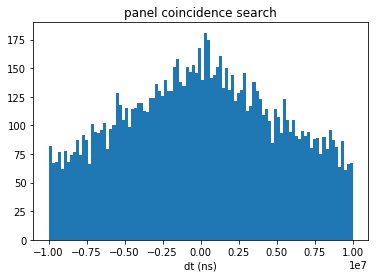

In [201]:
n, b, patches =plt.hist(coincidentList,bins=100,range=[-.01e9, .01e9])
plt.title("panel coincidence search")
plt.xlabel("dt (ns)")

In [185]:
jsonListPort0

['2023-06-16',
 '01:10:31.654825',
 81272.351243,
 1,
 '2023-06-16T01:10:31:654825000Z']

Text(0.5,0,'dt (ns)')

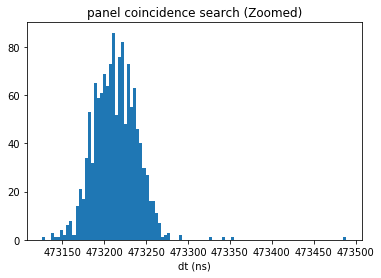

In [77]:
closeList = []
for i in coincidentList:
    if (i < 473500 and i > 473000):
        #print(i)
        closeList.append(i)
        
plt.hist(closeList,bins=100)
plt.title("panel coincidence search (Zoomed)")
plt.xlabel("dt (ns)")

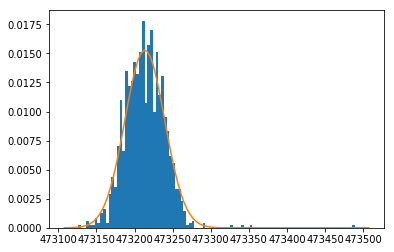

mean from fit = 473213.0 ns with std dev = 26.1 ns


In [83]:
from scipy.stats import norm


mean,std=norm.fit(closeList)
plt.hist(closeList, bins=100, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y)
plt.show()
print(f'mean from fit = {mean.round(0)} ns with std dev = {std.round(2)} ns')

In [80]:
mean

473213.4488721804

In [60]:
print(max(closeList)-min(closeList))

127


Text(0.5,0,'dt (ns)')

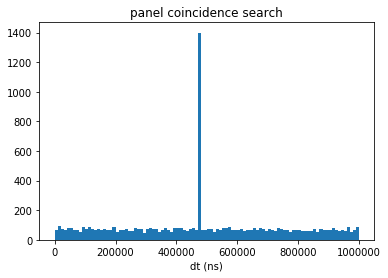

In [84]:
n, b, patches =plt.hist(coincidentList,bins=100,range=[0, 1000000])
plt.title("panel coincidence search")
plt.xlabel("dt (ns)")

In [85]:
bin_max = np.where(n == n.max())
print('maxbin', b[bin_max][0])

maxbin 470000.0


In [86]:
n[bin_max]

array([1399.])

In [ ]:
coincidentIndexList = []

coincidentTime = 1000
coincidenceList = []
lastJCount = 0
#for i in range(len(dfPort0)):
for i in range(10000):
    evTime = datetime.datetime.strptime(dfPort0.iloc[i, 0], '%H:%M:%S.%f')
    #print(evTime.time())
    if (lastJCount - 100 <0. ):
        lastJCount = 100
        #print('here')
    for j in range(lastJCount-100, len(dfPort1)):
        ev2Time = datetime.datetime.strptime(dfPort1.iloc[j, 0], '%H:%M:%S.%f')

            #ev2Time = datetime.datetime.strptime(dfPort1.iloc[i+j, 0], '%H:%M:%S.%f')
            #print(evTime.time(), ev2Time.time())
            #if( evTime + datetime.timedelta(microseconds = coincidentTime) < ev2Time):
            #    print(evTime.time(), ev2Time.time())
        timeDiff = abs(evTime-ev2Time)
        
        if timeDiff < datetime.timedelta(microseconds= coincidentTime):
            print('coincidence',timeDiff, evTime.time(), ev2Time.time())
            coincidenceList.append(timeDiff)
            coincidentIndexList.append([i,j])
        #print(abs(evTime-ev2Time))
        if(ev2Time > evTime + datetime.timedelta(microseconds = coincidentTime*2)):
            lastJCount = j
            #print(lastJCount)
            #print('over')
            break
            
#print("--- %s seconds ---" % (time.time() - start_time))
print(f'coincidences found at {coincidentTime} microseconds = {len(coincidenceList)}')

# old coincidence

In [ ]:
coincidentIndexList = []

coincidentTime = 1000
coincidenceList = []
lastJCount = 0
for i in range(len(dfPort0)):
#for i in range(10000):
    evTime = datetime.datetime.strptime(dfPort0.iloc[i, 0], '%H:%M:%S.%f')
    #print(evTime.time())
    if (lastJCount - 100 <0. ):
        lastJCount = 100
        #print('here')
    for j in range(lastJCount-100, len(dfPort1)):
        ev2Time = datetime.datetime.strptime(dfPort1.iloc[j, 0], '%H:%M:%S.%f')

            #ev2Time = datetime.datetime.strptime(dfPort1.iloc[i+j, 0], '%H:%M:%S.%f')
            #print(evTime.time(), ev2Time.time())
            #if( evTime + datetime.timedelta(microseconds = coincidentTime) < ev2Time):
            #    print(evTime.time(), ev2Time.time())
        timeDiff = abs(evTime-ev2Time)
        
        if timeDiff < datetime.timedelta(microseconds= coincidentTime):
            print('coincidence',timeDiff, evTime.time(), ev2Time.time())
            coincidenceList.append(timeDiff)
            coincidentIndexList.append([i,j])
        #print(abs(evTime-ev2Time))
        if(ev2Time > evTime + datetime.timedelta(microseconds = coincidentTime*2)):
            lastJCount = j
            #print(lastJCount)
            #print('over')
            break
            
#print("--- %s seconds ---" % (time.time() - start_time))
print(f'coincidences found at {coincidentTime} microseconds = {len(coincidenceList)}')

In [ ]:
pltList = []
for i in coincidenceList:
    pltList.append(i.microseconds)


plt.hist(pltList,bins=100)
plt.yscale('log')
plt.title("first pass coincidence time search")
plt.xlabel("dt of events(microsecond)")
#plt.savefig("coincidenceHistogram.png")
print(statistics.mode(pltList))

In [ ]:
coincidentIndexList = []

coincidentTime = statistics.mode(pltList)
coincidenceList = []
lastJCount = 0
for i in range(len(dfPort0)):
#for i in range(1000):
    evTime = datetime.datetime.strptime(dfPort0.iloc[i, 0], '%H:%M:%S.%f')
    #print(evTime.time())
    if (lastJCount - 100 <0. ):
        lastJCount = 100
        #print('here')
    for j in range(lastJCount-100, len(dfPort1)):
        ev2Time = datetime.datetime.strptime(dfPort1.iloc[j, 0], '%H:%M:%S.%f')

            #ev2Time = datetime.datetime.strptime(dfPort1.iloc[i+j, 0], '%H:%M:%S.%f')
            #print(evTime.time(), ev2Time.time())
            #if( evTime + datetime.timedelta(microseconds = coincidentTime) < ev2Time):
            #    print(evTime.time(), ev2Time.time())
        timeDiff = abs(evTime-ev2Time)
        
        if timeDiff < datetime.timedelta(microseconds= coincidentTime+2) and timeDiff > datetime.timedelta(microseconds= coincidentTime-2):
            print('coincidence',timeDiff, evTime.time(), ev2Time.time())
            coincidenceList.append(timeDiff)
            coincidentIndexList.append([i,j])
        #print(abs(evTime-ev2Time))
        if(ev2Time > evTime + datetime.timedelta(microseconds = coincidentTime*2)):
            lastJCount = j
            #print(lastJCount)
            #print('over')
            break
            
#print("--- %s seconds ---" % (time.time() - start_time))
print(f'coincidences found at {coincidentTime} microseconds = {len(coincidenceList)}')

In [ ]:
print(f'coincidences found at {coincidentTime} microseconds = {len(coincidenceList)}')

In [ ]:
coincidentIndexList

In [ ]:
p0adc1CoincidentValuesList = []
p0adc2CoincidentValuesList = []
p1adc1CoincidentValuesList = []
p1adc2CoincidentValuesList = []
for i in coincidentIndexList:
    p0adc1CoincidentValuesList.append(dfPort0.iloc[i[0], 1])
    p1adc1CoincidentValuesList.append(dfPort1.iloc[i[1], 1])
    #print(dfPort1.iloc[i[0],1])
    p0adc2CoincidentValuesList.append(dfPort0.iloc[i[0], 2])
    p1adc2CoincidentValuesList.append(dfPort1.iloc[i[1], 2])
    #print(i)

plt.subplot(1,2,1)
plt.suptitle(f'Panel {jsonListPort0[3]}')
plt.hist(p0adc1CoincidentValuesList, histtype='step', bins=100)
modeList = []
for i in p0adc1CoincidentValuesList:
    if i!= 4095:
        modeList.append(i)
plt.axvline(x = statistics.mode(modeList), label = f' VEM = {statistics.mode(modeList)}', color='r')
plt.title('High Gain')
plt.ylabel('counts')
plt.legend()
plt.xlabel('adc charge')

plt.subplot(1,2,2)
plt.hist(p0adc2CoincidentValuesList, histtype='step', bins=100)
modeList = []
for i in p0adc2CoincidentValuesList:
    if i!= 4095:
        modeList.append(i)
plt.axvline(x = statistics.mode(modeList), label = f' VEM = {statistics.mode(modeList)}', color='r')
plt.title('medium Gain')
plt.ylabel('counts')
plt.xlabel('adc charge')
#plt.savefig(f'panel{jsonListPort0[3]}VEM.png')
plt.legend()
plt.subplots_adjust(left =.1,right = .9, wspace = .5)
plt.show()

plt.subplot(1,2,1)
plt.suptitle(f'Panel {jsonListPort1[3]}')
plt.hist(p1adc1CoincidentValuesList, histtype='step', bins=100)
modeList = []
for i in p1adc1CoincidentValuesList:
    if i!= 4095:
        modeList.append(i)
plt.axvline(x = statistics.mode(modeList), label = f' VEM = {statistics.mode(modeList)}', color='r')
plt.legend()
plt.title('High Gain')
plt.ylabel('counts')
plt.xlabel('adc charge')

plt.subplot(1,2,2)
plt.hist(p1adc2CoincidentValuesList, histtype='step', bins=100)
modeList = []
for i in p1adc2CoincidentValuesList:
    if i!= 4095:
        modeList.append(i)
plt.axvline(x = statistics.mode(modeList), label = f' VEM = {statistics.mode(modeList)}', color='r')
plt.legend()
plt.title('medium Gain')
plt.ylabel('counts')
plt.xlabel('adc charge')
#plt.savefig('coincidentEventCharge.png')
#plt.savefig(f'panel{jsonListPort1[3]}VEM.png')

plt.subplots_adjust(left =.1,right = .9, wspace = .5)
plt.show()